In [7]:
import pandas as pd, numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
stations=pd.read_csv('data/stations.csv').set_index('ID')

Setup plot params

In [89]:
def get_country(c,h='hs',plot=False):
    if c=='huro':
        hu=pd.read_csv('data/'+'hu'+'_'+h+'.csv') #daily data
        ro=pd.read_csv('data/'+'ro'+'_'+h+'.csv') #daily data
        df=pd.concat([hu,ro])
    else:
        df=pd.read_csv('data/'+c+'_'+h+'.csv') #daily data
        # df=pd.read_csv('data/'+c+'_hs.csv') #high_res data
    df['time']=pd.to_datetime(df['time'])
    df['year']=df['time'].dt.year
    df['month']=df['time'].dt.month
    df['day']=df['time'].dt.day
    df['hour']=df['time'].dt.hour
    df=df.set_index('time')
    df=df.sort_index()
    if plot: df.groupby('year').nunique()['ID'].plot()
    return df

Re-run this section for `ro`, `hu` and `huro`

In [380]:
c='huro'
if c!='huro':
    df=get_country(c,plot=True)
    df_ro=df.copy()
    # df_hu=df.copy()
else:
    df=pd.concat([df_ro,df_hu])

In [382]:
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))/1000

In [383]:
coerce={}
for i1 in range(len(stations.index)):
    station1=stations.index[i1]
    for i2 in range(i1,len(stations.index)):
        station2=stations.index[i2]
        if station1!=station2:
            if haversine(stations.loc[station1][['LAT','LON']].values,
            stations.loc[station2][['LAT','LON']].values)<10:
                print(station1,station2,stations.loc[station1]['LOC'],stations.loc[station2]['LOC'])
                if station2 not in coerce:
                    if station1 in coerce:
                        coerce[station2]=coerce[station1]
                    else:
                        coerce[station2]=station1

119000 151630 BAISOARA BAISOARA
152000 152005 ARAD ARAD
154200 154210 AUREL VLAICU HENRI COANDA
154200 154220 AUREL VLAICU BUCURESTI FILARET
150230 150235 STEFAN CEL MARE SUCEAVA/SALCEA
150320 150330 RODNEI MOUNTAIN RNG IEZER
150400 150520 CIMPULUNG MOLDOVENE RARAU
150890 151080 CEAHLAU CEAHLAU TOACA
151200 151205 CLUJ NAPOCA CLUJ-NAPOCA/SOMESEN
151400 151600 STEIU STEI
151620 151840 CAMPENI ROSIA MONTANA
152590 152820 POSTAVARU POIANA BRASOV
152590 153020 POSTAVARU PREDEAL
152960 153200 PETROSANI PARANG
152990 153010 RUCAR FUNDATA
153160 153170 CUNTU TARCU
153200 153210 PARANG PARING (AUT)
153350 153355 CATALOI TULCEA/CATALOI
154230 154430 DILGA DOR MARUNT
154500 154510 CRAIOVA CRAIOVA
154930 154931 TUZLA TUZLA
128300 697204 VESZPREM/SZENTKIRALYSZABADJA VARPALOTA TRAINING AREA / EXER
128305 128440 TOKOL TOKOL
128380 128400 BUDAORS BUDAPEST MET CENTER
128390 128430 FERIHEGY BUDAPEST/PESTSZENTLORINC
128601 128603 AZENTKILYSZABADJA SZENTKIRALYSZABADJA
128601 697204 AZENTKILYSZABADJA VARP

In [384]:
df['ID']=df['ID'].replace(coerce)

In [385]:
station_list=df['ID'].unique()

In [386]:
coerce={}
for i1 in range(len(station_list)):
    station1=station_list[i1]
    for i2 in range(i1,len(station_list)):
        station2=station_list[i2]
        if station1!=station2:
            if haversine(stations.loc[station1][['LAT','LON']].values,
            stations.loc[station2][['LAT','LON']].values)<10:
                print(station1,station2,stations.loc[station1]['LOC'],stations.loc[station2]['LOC'])
                if station2 not in coerce:
                    if station1 in coerce:
                        coerce[station2]=coerce[station1]
                    else:
                        coerce[station2]=station1

If nothing found continue, otherwise loop.

In [398]:
keys=['XTEMP','XSPD','XVSB']
dz=df.groupby(['ID','month','hour','year']).median()[keys]
#universal mean
dzm=dz.groupby(['ID','month','hour']).median()[keys]
#or last 10 mean
dzm10=df[df['year'].isin(range(2009,2020))].groupby(['ID','month','hour']).median()[keys]
dzn=dz-dzm
dzn10=dz-dzm10
dzp=dzn.groupby(['ID','year']).median()
dzp10=dzn10.groupby(['ID','year']).median()
#get outliers
dws=[]
for station in dzp.index.get_level_values(0).unique():
    dw=dzp.loc[station][['XTEMP']]
    dw['z']=np.abs(stats.zscore(dw).flatten())
    dw=dw[dw['z']<3]
    dw['ID']=station
    dws.append(dw)
dws=pd.concat(dws)
#slice under new index
dzp=dzp.loc[dws.reset_index().set_index(['ID','year']).index]
dzp10=dzp10.loc[dws.reset_index().set_index(['ID','year']).index]
#export
dzr=(((dzp-dzp.groupby('ID').min())/(dzp.groupby('ID').max()-dzp.groupby('ID').min()))*2)-1
dzr.columns=[i.replace('X','N') for i in dzr.columns]
dzp10.columns=[i+'10' for i in dzp10.columns]
dzq=dzp.join(dzp10).join(dzr).join(stations[['LOC','LAT','LON','ELEVATION']])

In [399]:
for i in [10,20,30,40,50,60]:
    dk=dzq.reset_index().set_index('ID').loc[dzp.groupby(['ID']).count()['XTEMP']>i]
    dk.to_csv('stripes/'+c+'_'+str(i)+'.csv')
    if i==40:
        dk.to_csv('stripes/'+c+'.csv')
        translated_stations=dk.index.unique()

Stations - only for `huro`

In [370]:
import json

In [371]:
namer=json.loads(open('data/namer.json','r').read())

In [393]:
for i in stations.loc[translated_stations]['LOC'].values:
    if i not in namer: 
        print('"'+i+'":"'+i.capitalize()+'",')

"BALATON":"Balaton",
"PECS":"Pecs",
"SIGHETUL MARMATIEI":"Sighetul marmatiei",
"CEAHLAU":"Ceahlau",
"ARAD":"Arad",
"POSTAVARU":"Postavaru",
"CRAIOVA":"Craiova",
"TURNU-MAGURELE":"Turnu-magurele",


In [394]:
namer2={
"BAISOARA":"Băișoara",
"AVRAMENI":"Avrameni",
"BAIA MARE/MAGHERUSI":"Nagybánya - Miszmogyorós",
"BISTRITA":"Beszterce",
"BARNOVA":"Iași / Bârnova",
"BATOS":"Bátos",
"BAISOARA":"Băișoara",
"BARLAD":"Bârlad",
"ARAD":"Arad",
"ALBA IULIA":"Gyulafehérvár",
"BLAJ":"Balázsfalva",
"BARAOLT":"Barót",
"ADJUD":"Adjud",
"BALINTESTI":"Bălintețti",
"BALEA LAC":"Bâlea-tó",
"BISOCA":"Bisoca",
"BANLOC":"Bánlak",
"APA NEAGRA":"Apa Neagră",
"BAILE HERCULANE":"Herkulesfürdő",
"BERZASCA":"Berzasca",
"BACLES":"Bâcleș",
"BAILESTI":"Băilești",
"ADAMCLISI":"Adamclisi",
"ALEXANDRIA":"Alexandria",
"BECHET":"Bechet",
"DARABANI":"Darabani",
"BORCEA FETESTI AIR BASE":"Fetești légibázis",
"SIGHETUL MARMATIEI":"Máramarossziget",
"RADAUTI":"Rădăuți",
"DOROHOI":"Dorohoi",
"SUCEAVA/SALCEA":"Suceava",
"BALATON":"Balaton",
"PECS":"Pécs",
"CEAHLAU":"Csalhó",
"ARAD":"Arad",
"POSTAVARU":"Postăvaru-csúcs",
"CRAIOVA":"Craiova",
"TURNU-MAGURELE":"Turnu Măgurele"}

In [395]:
namer.update(namer2)

In [397]:
open('data/namer.json','w').write(json.dumps(namer))

3256

Carpet plots

In [404]:
dzn10.loc[station].groupby(['year','month']).median()[['XTEMP']].reset_index()

XTEMP
year month          
1964 1     -4.444444
     2     -2.916667
     3     -4.166667
     4     -2.777778
     5     -3.333333
...              ...
2019 6      2.361111
     7      0.000000
     8     -0.416667
     9      0.000000
     10     7.222222

[457 rows x 1 columns]

In [410]:
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



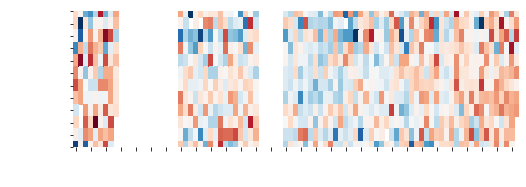

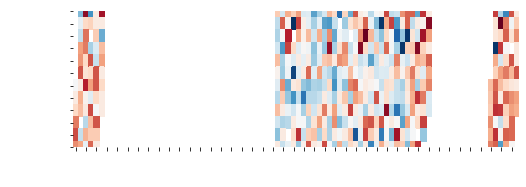

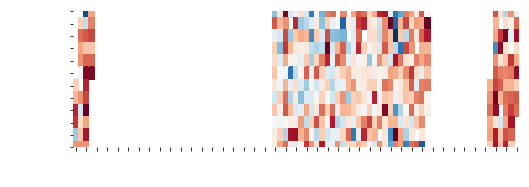

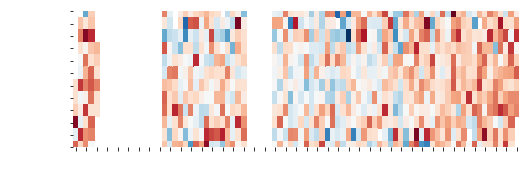

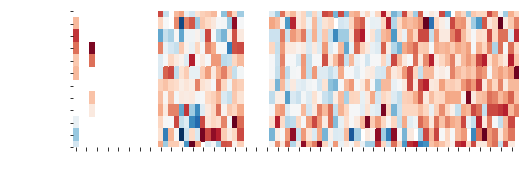

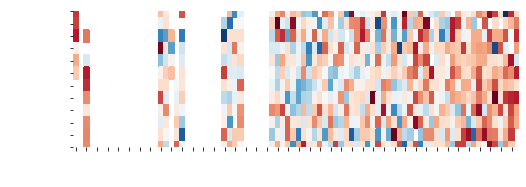

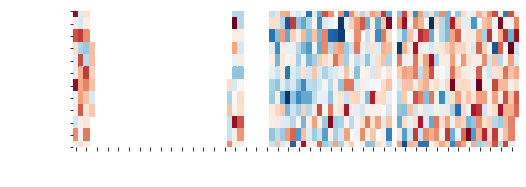

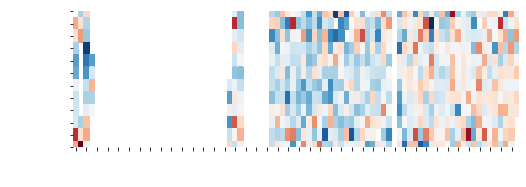

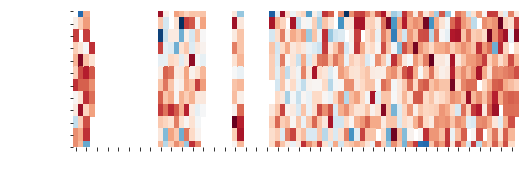

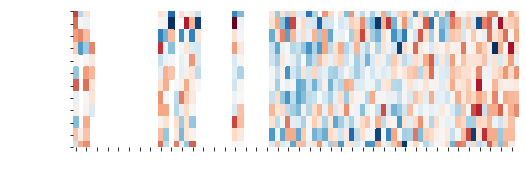

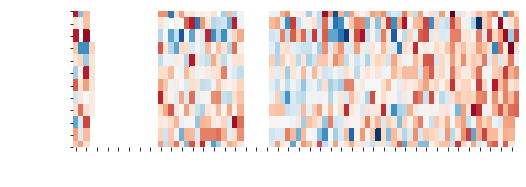

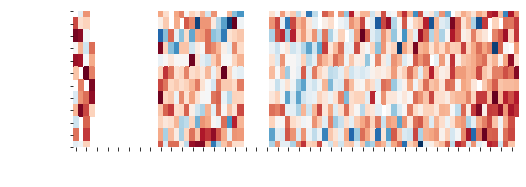

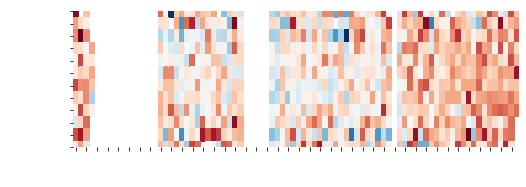

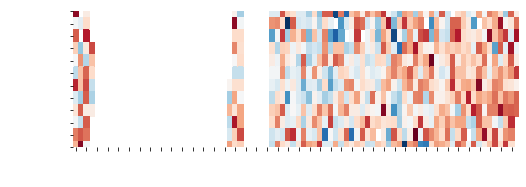

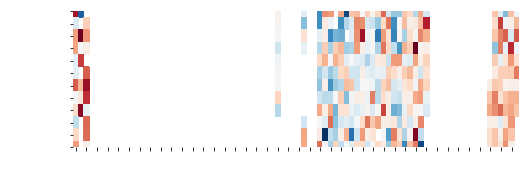

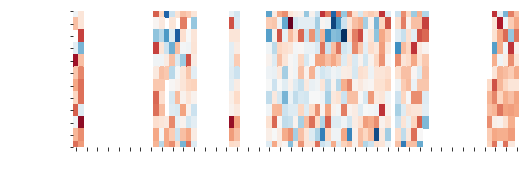

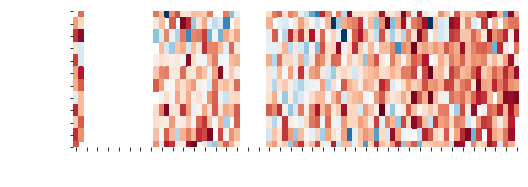

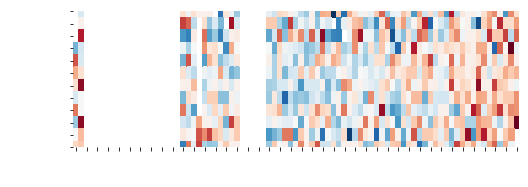

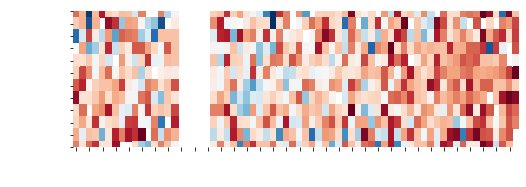

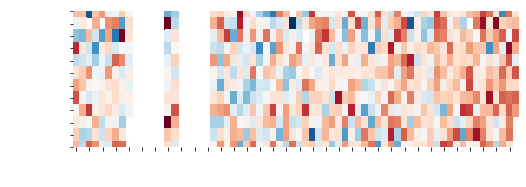

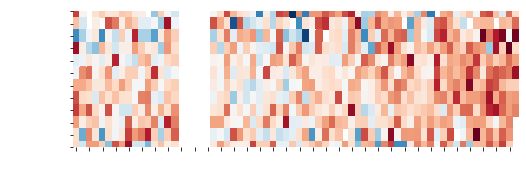

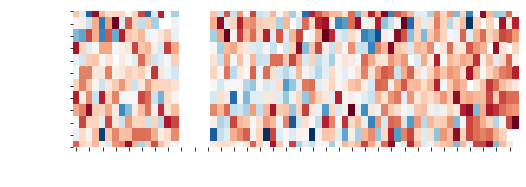

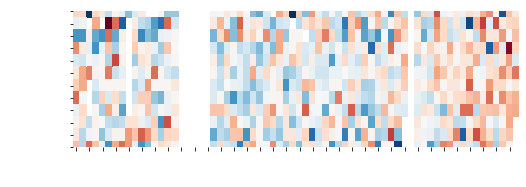

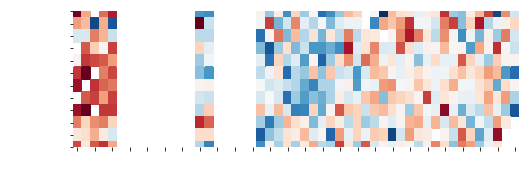

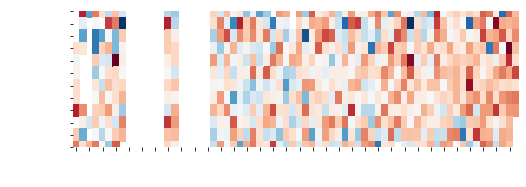

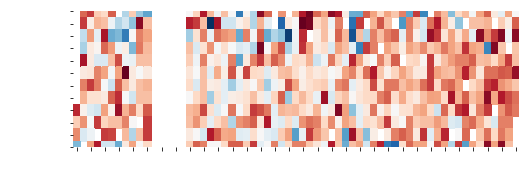

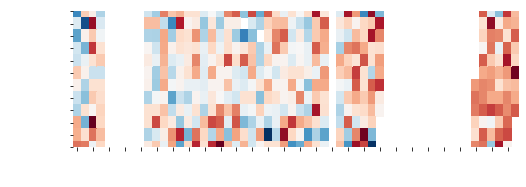

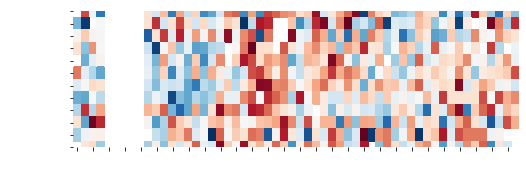

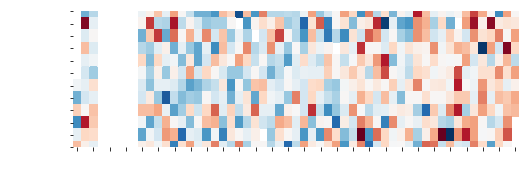

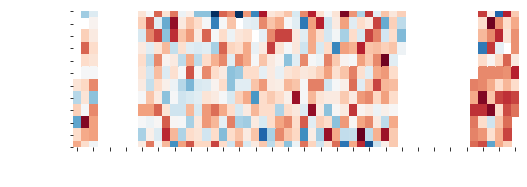

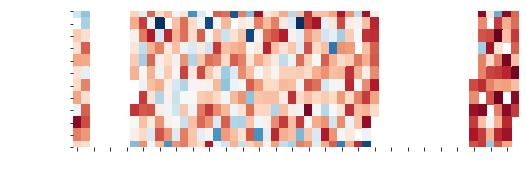

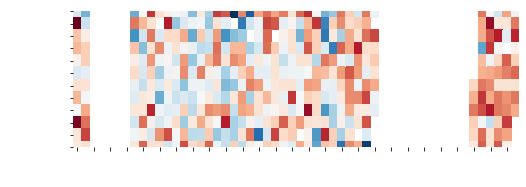

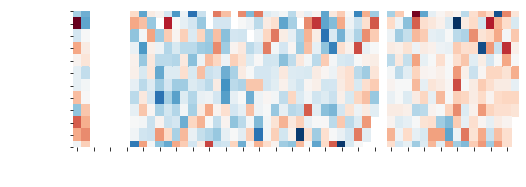

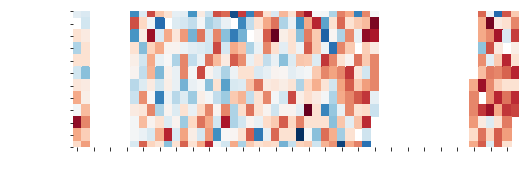

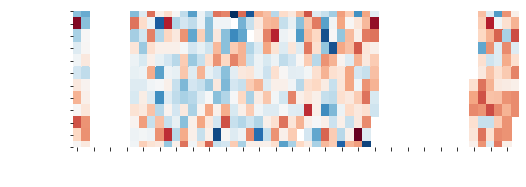

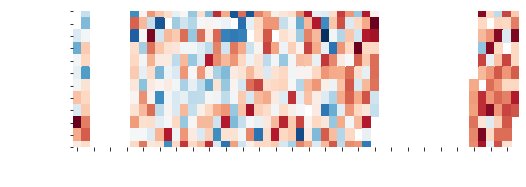

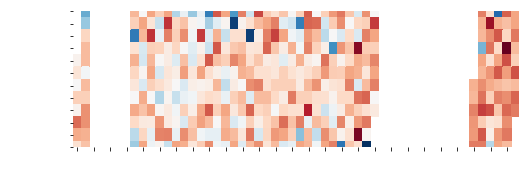

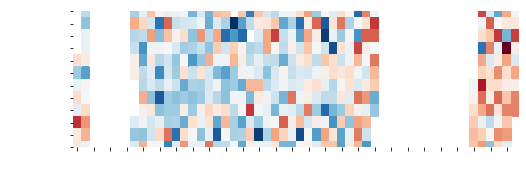

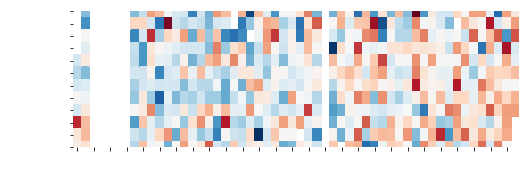

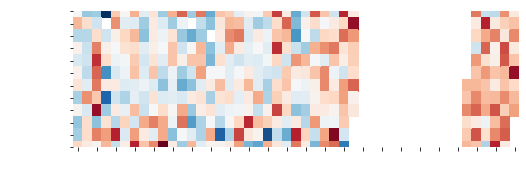

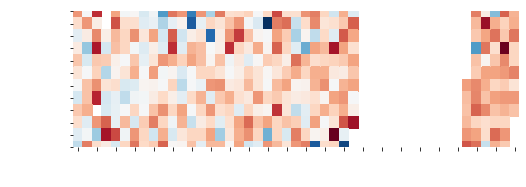

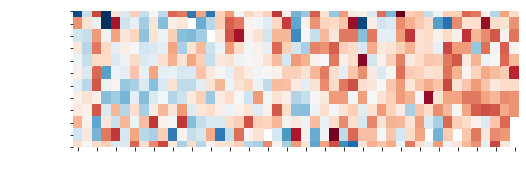

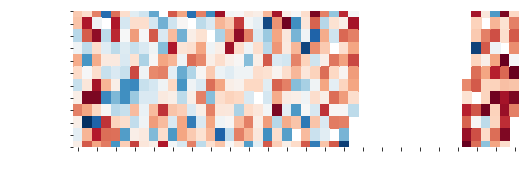

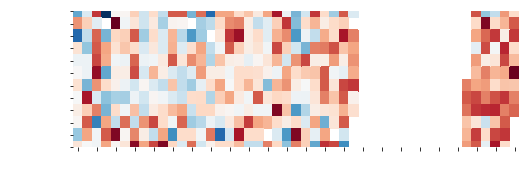

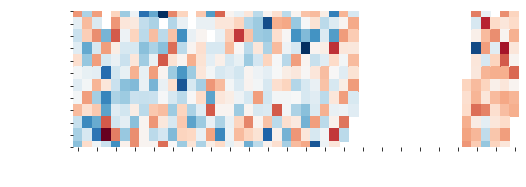

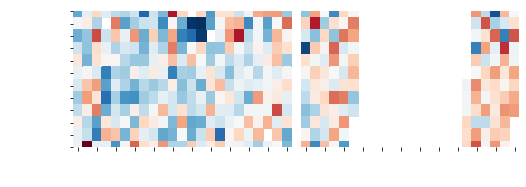

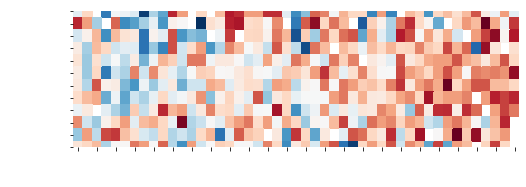

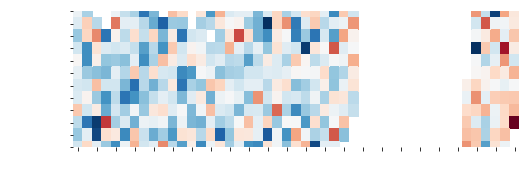

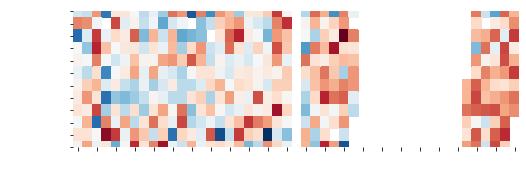

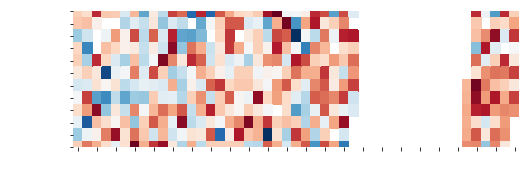

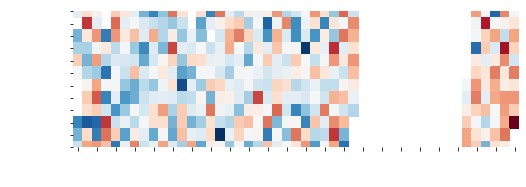

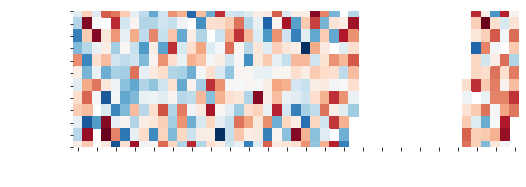

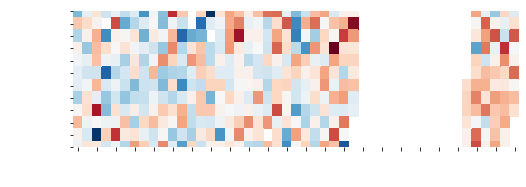

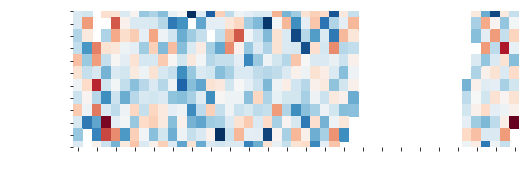

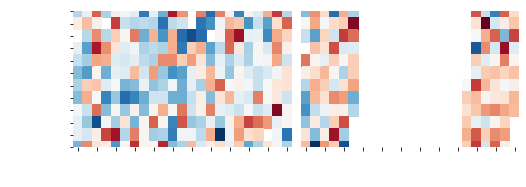

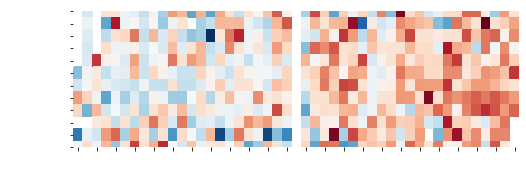

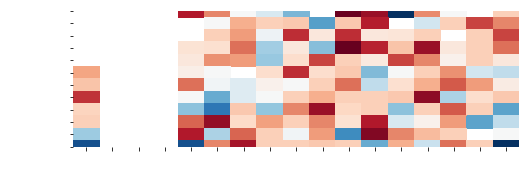

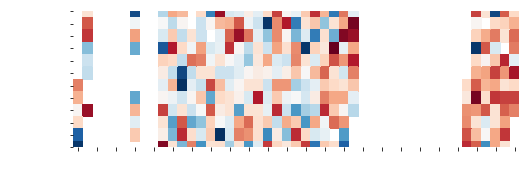

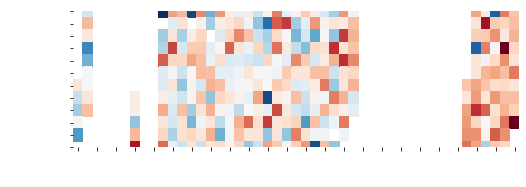

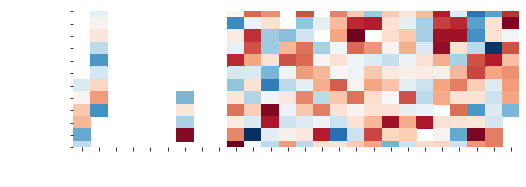

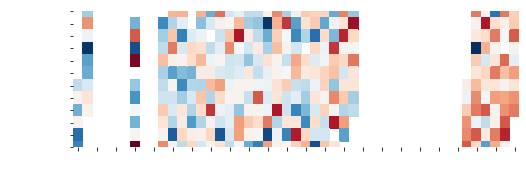

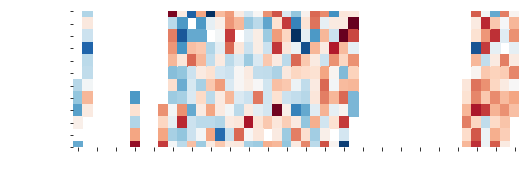

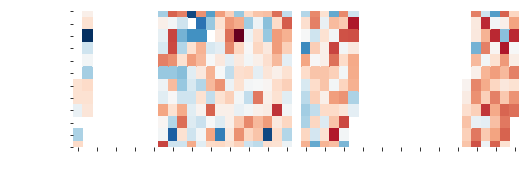

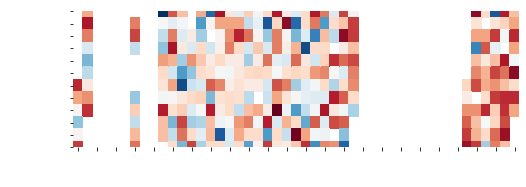

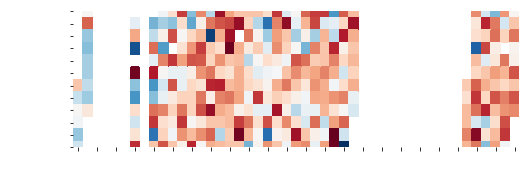

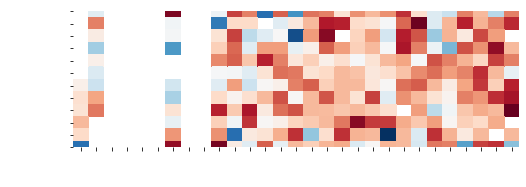

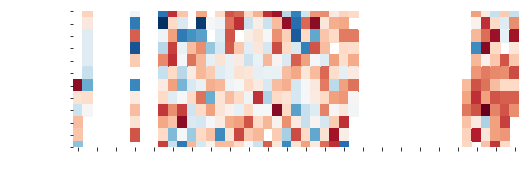

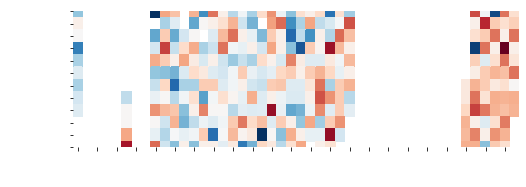

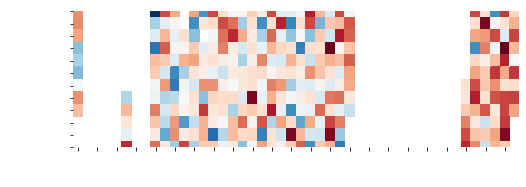

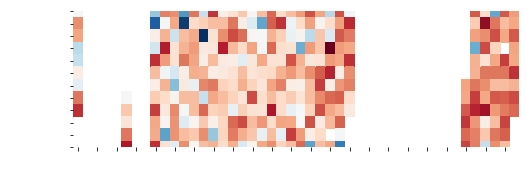

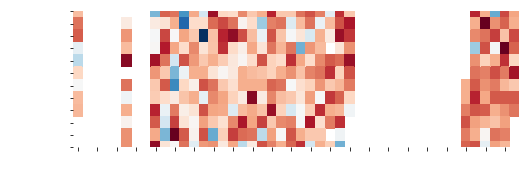

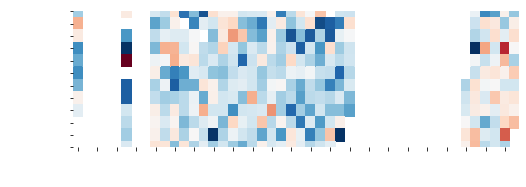

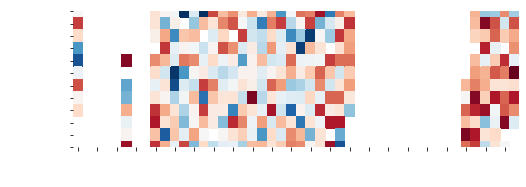

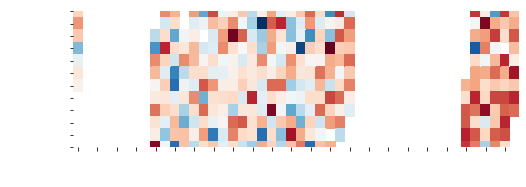

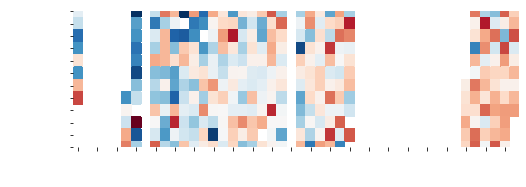

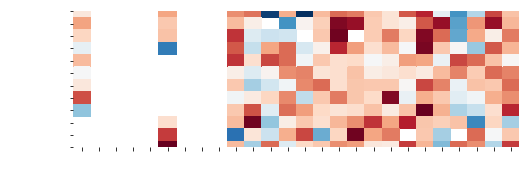

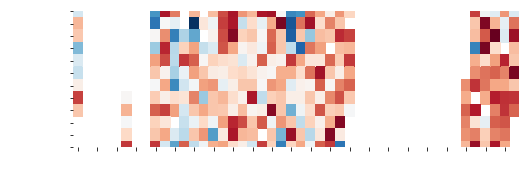

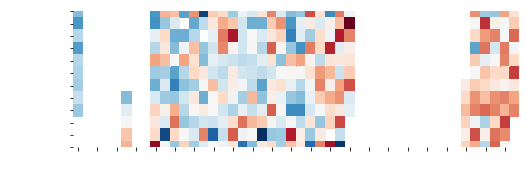

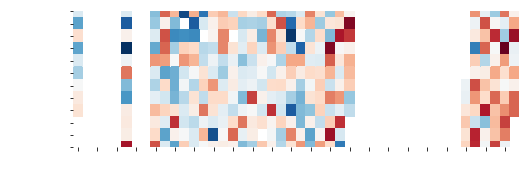

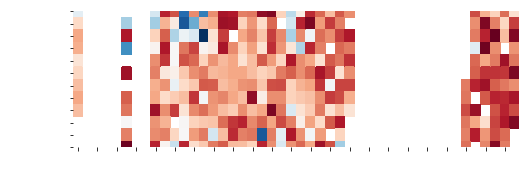

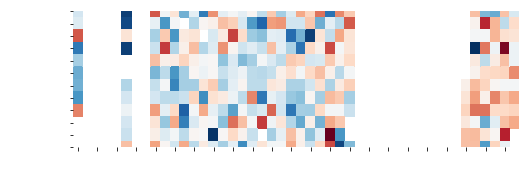

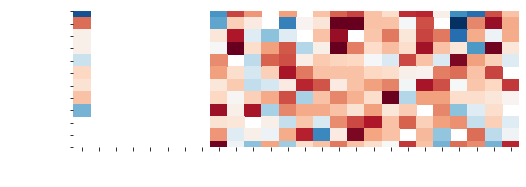

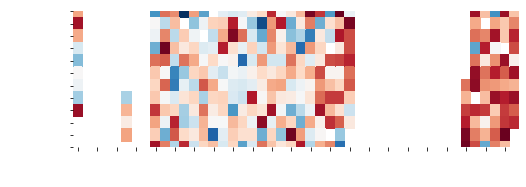

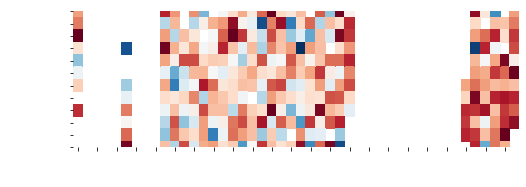

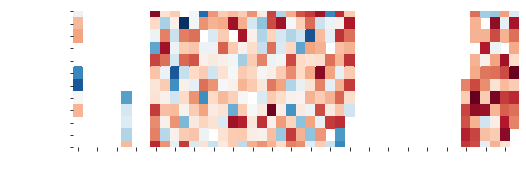

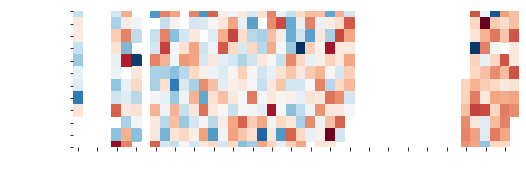

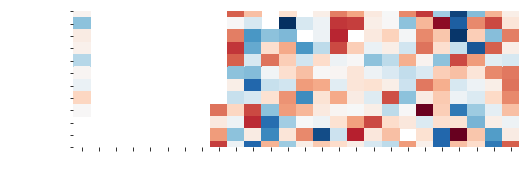

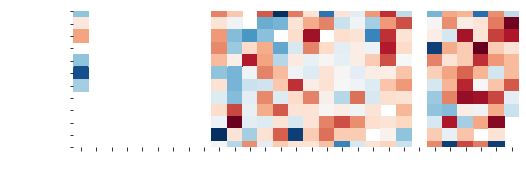

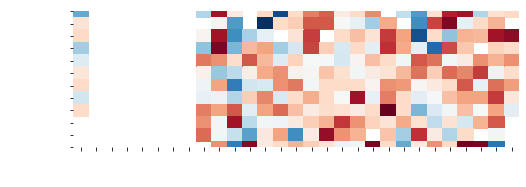

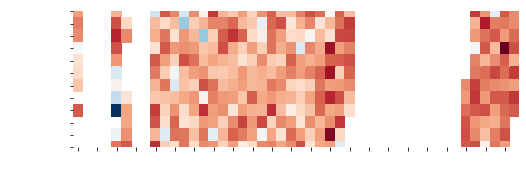

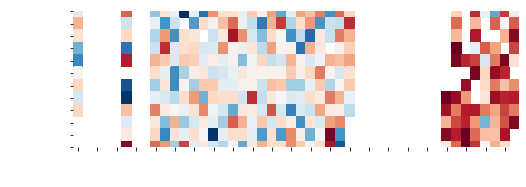

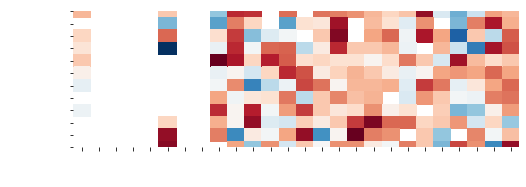

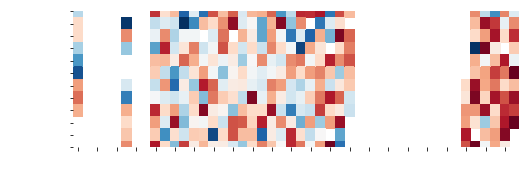

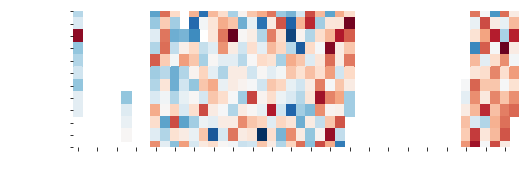

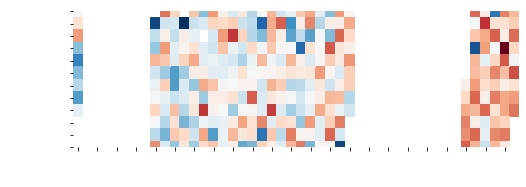

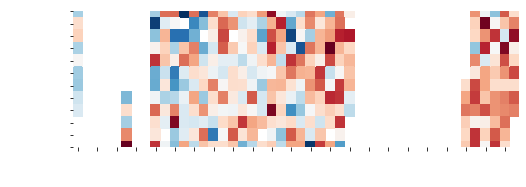

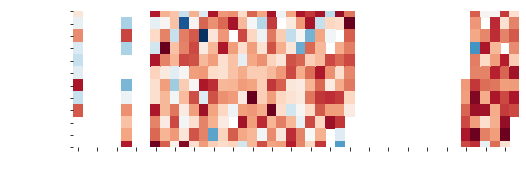

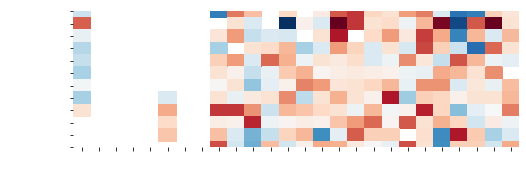

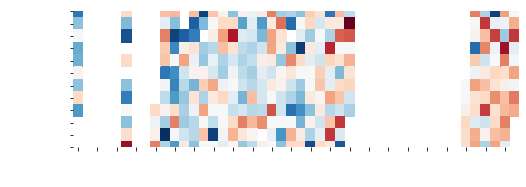

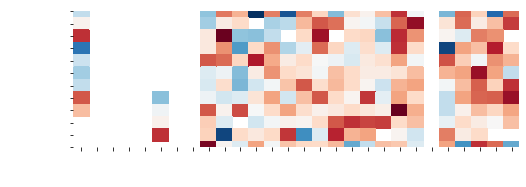

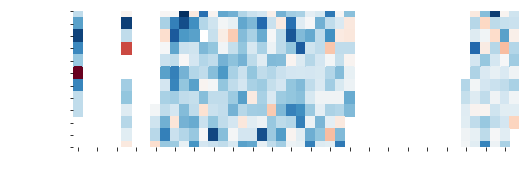

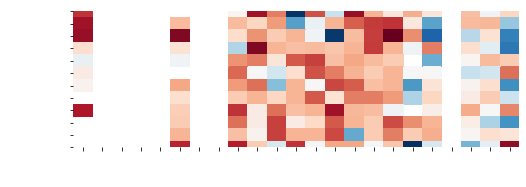

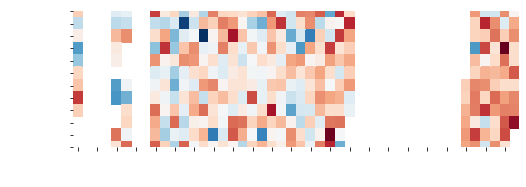

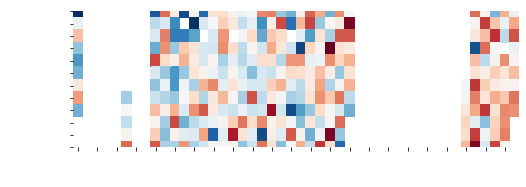

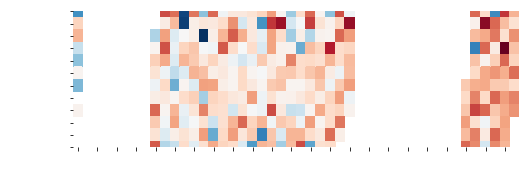

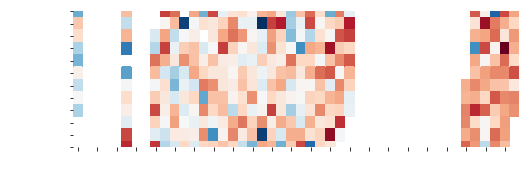

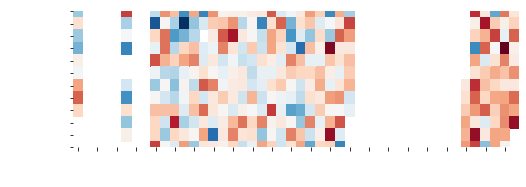

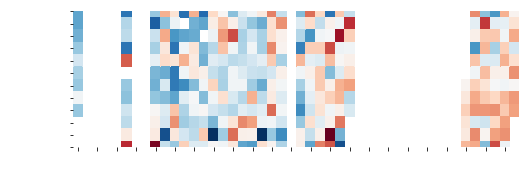

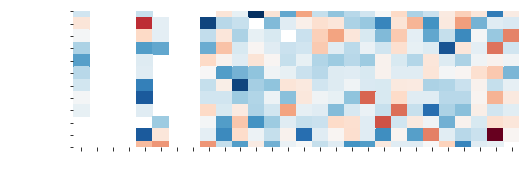

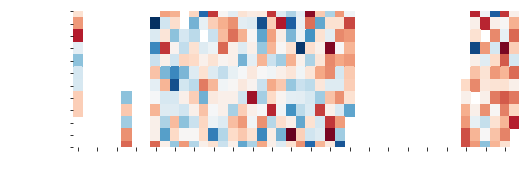

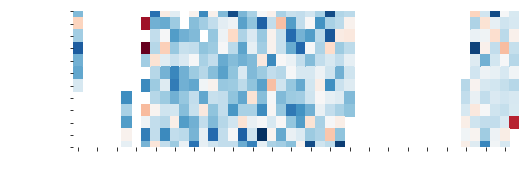

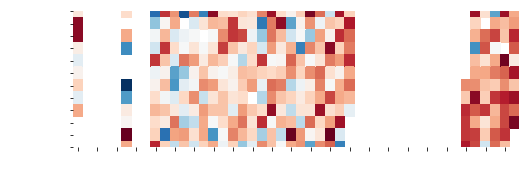

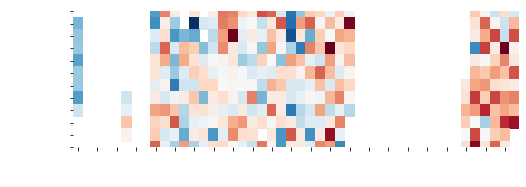

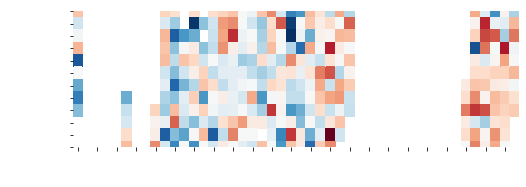

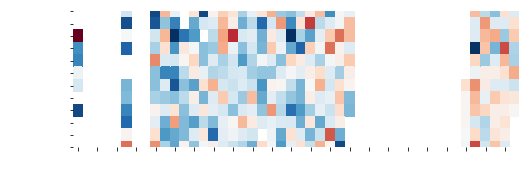

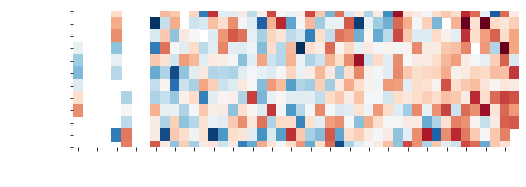

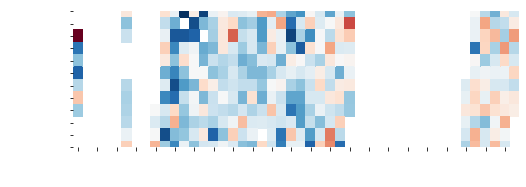

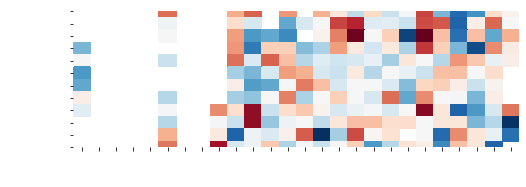

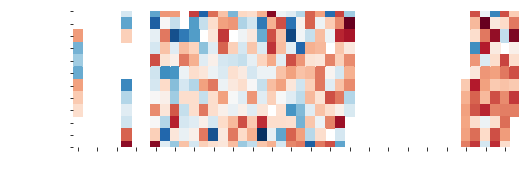

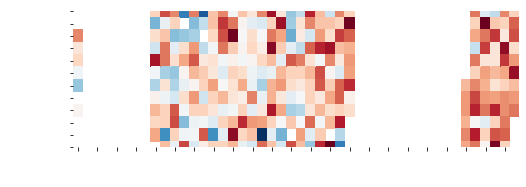

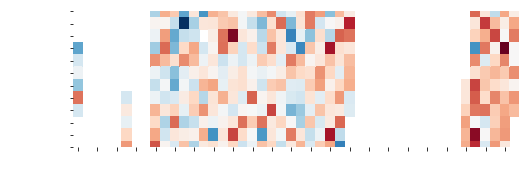

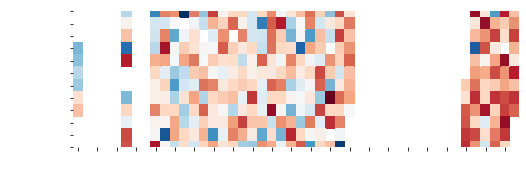

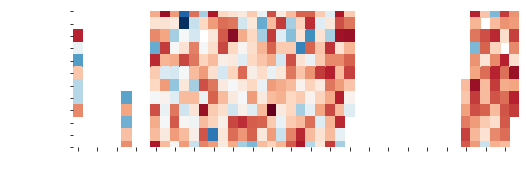

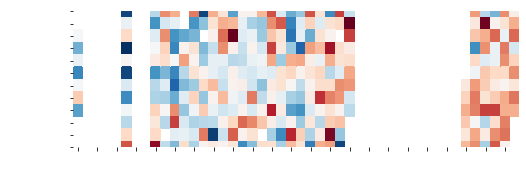

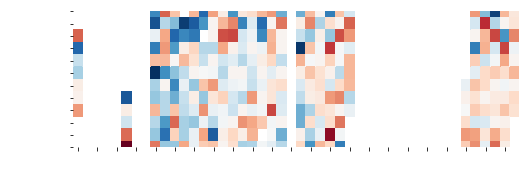

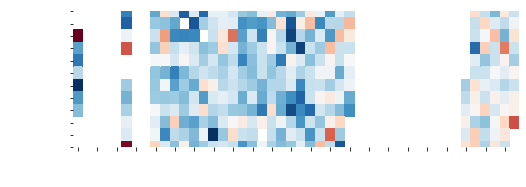

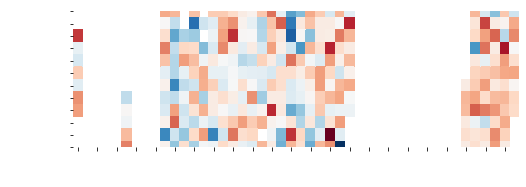

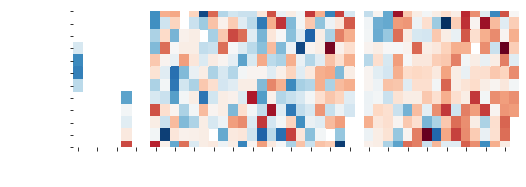

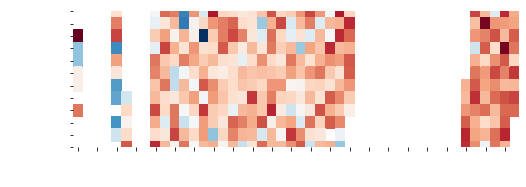

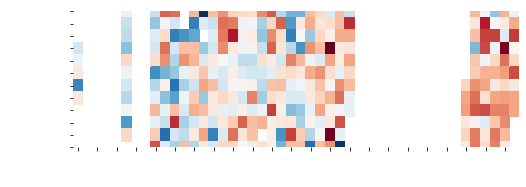

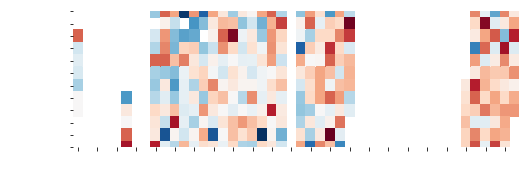

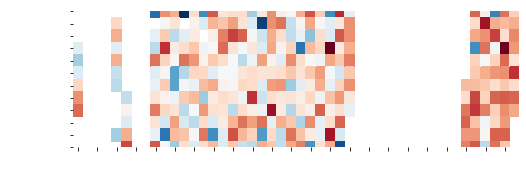

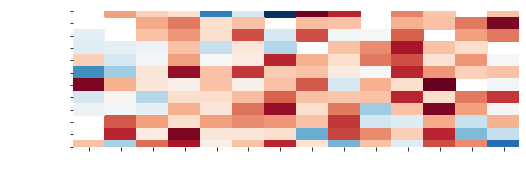

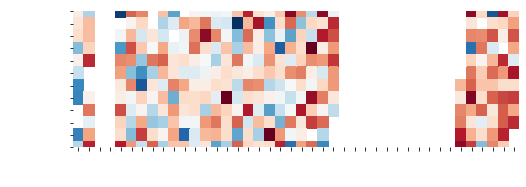

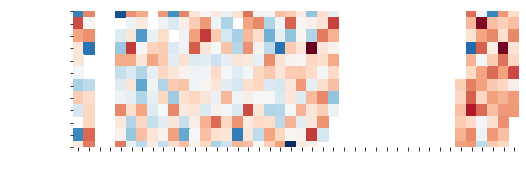

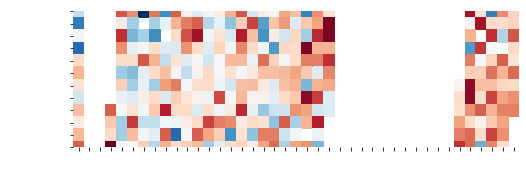

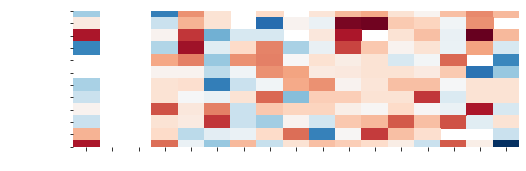

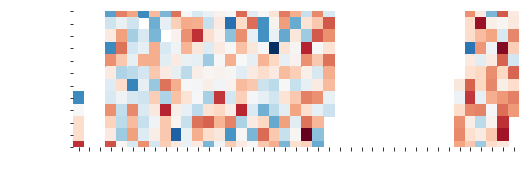

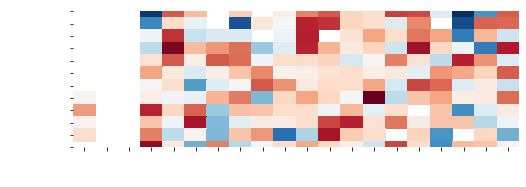

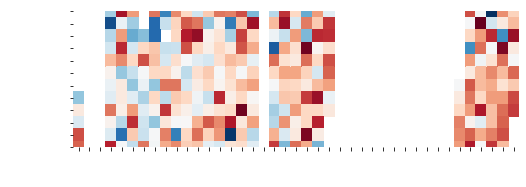

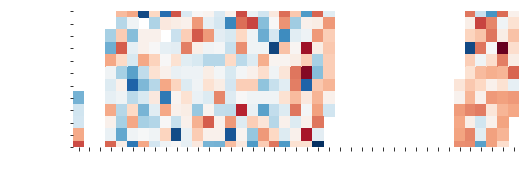

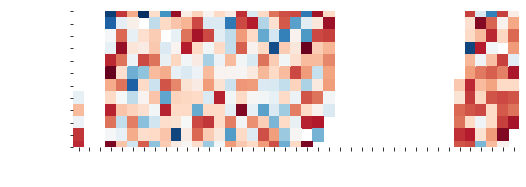

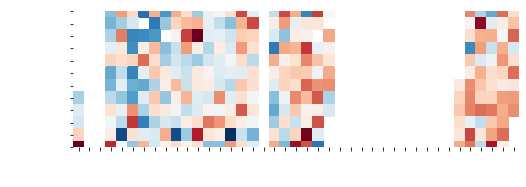

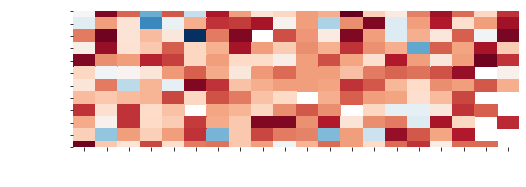

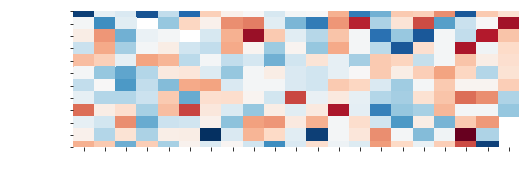

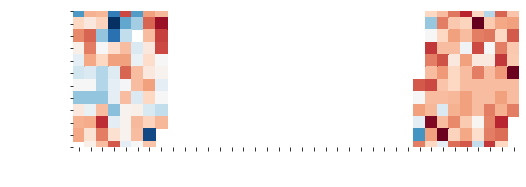

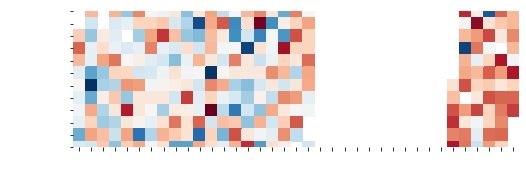

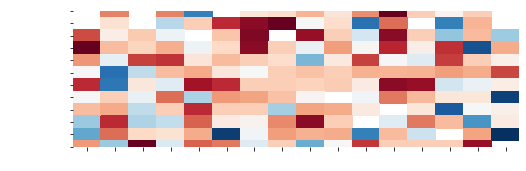

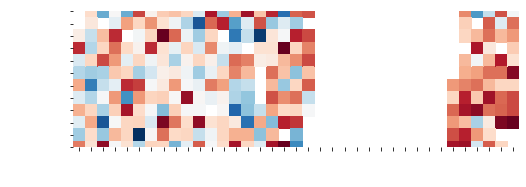

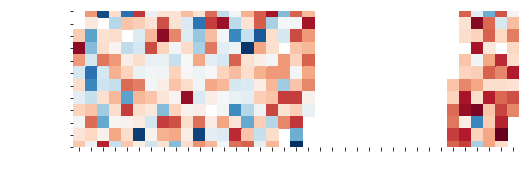

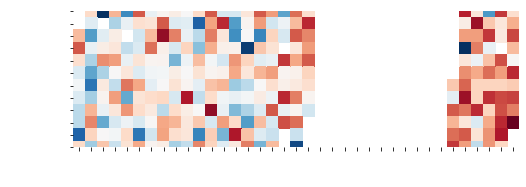

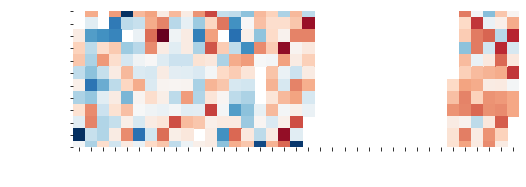

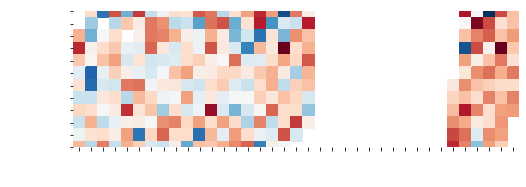

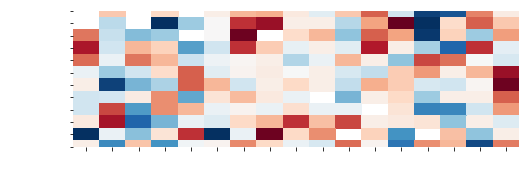

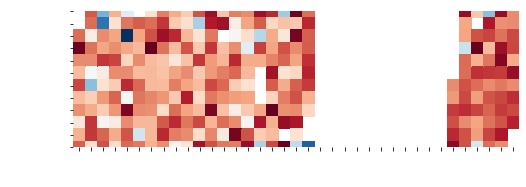

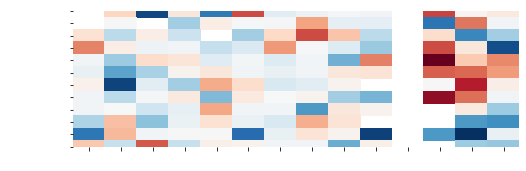

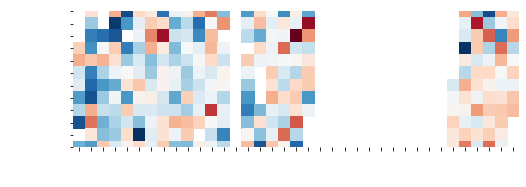

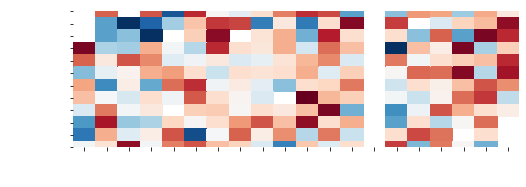

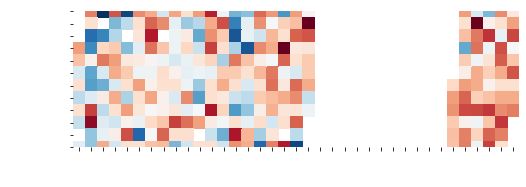

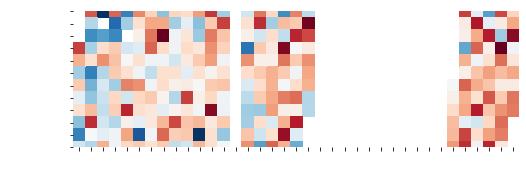

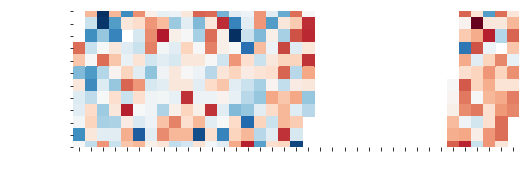

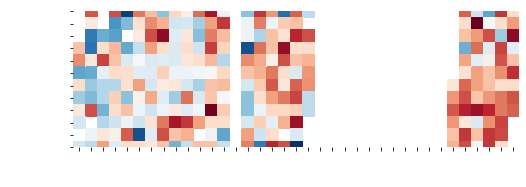

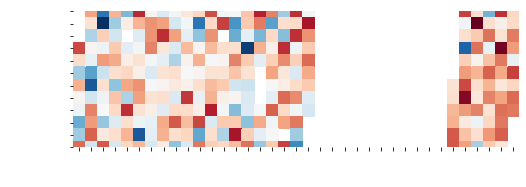

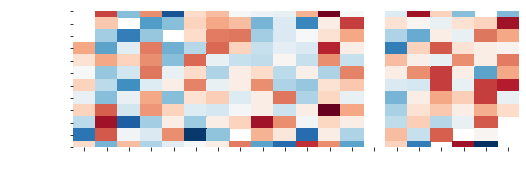

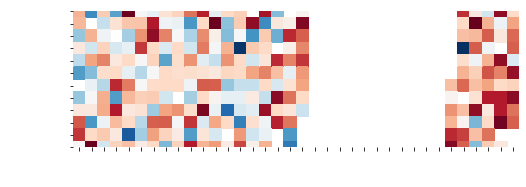

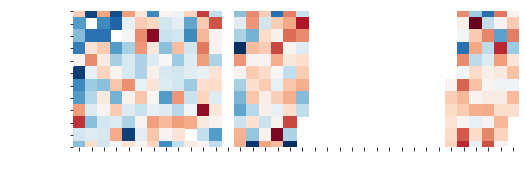

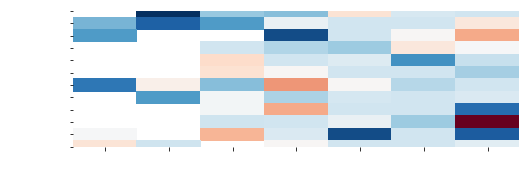

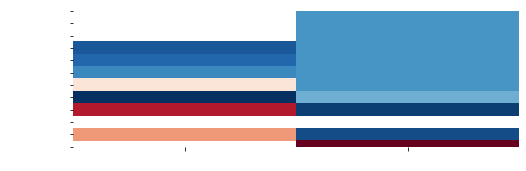

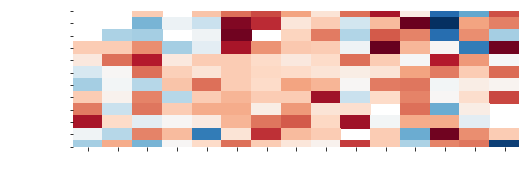

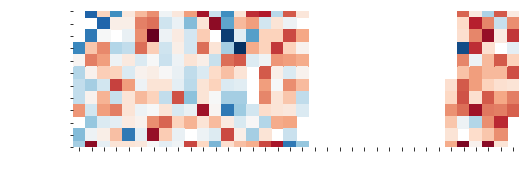

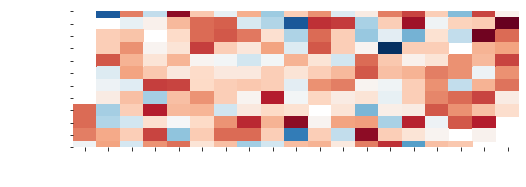

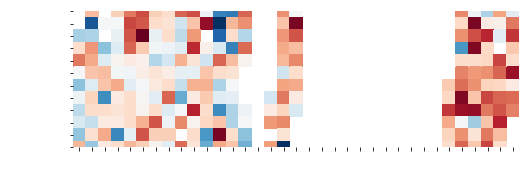

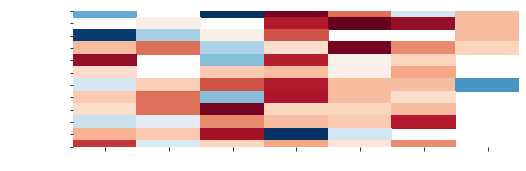

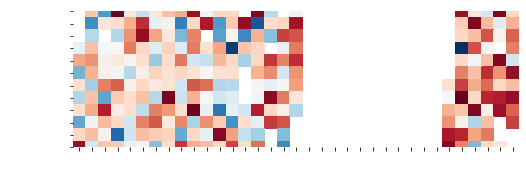

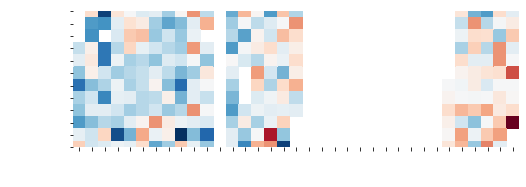

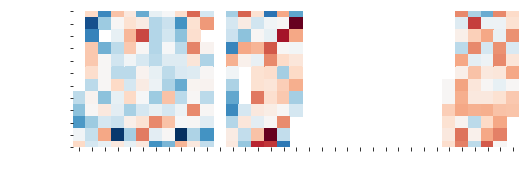

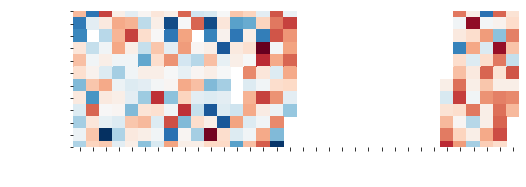

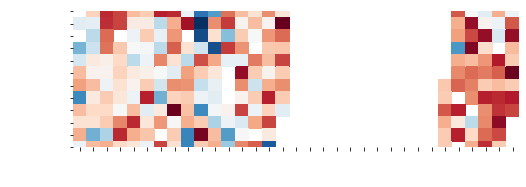

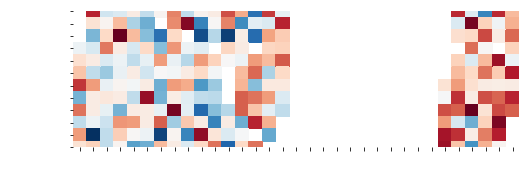

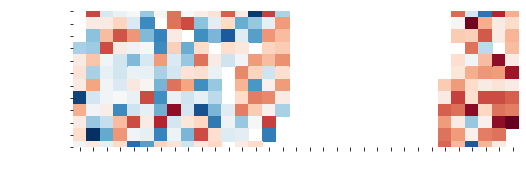

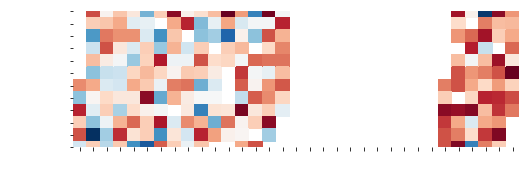

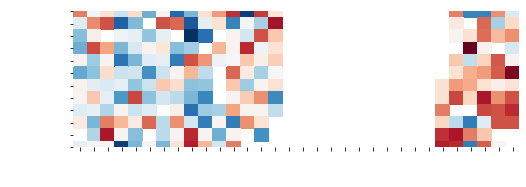

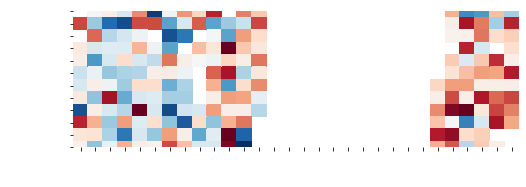

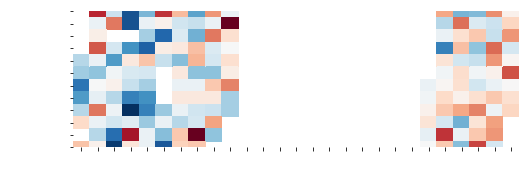

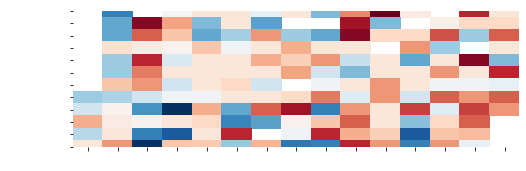

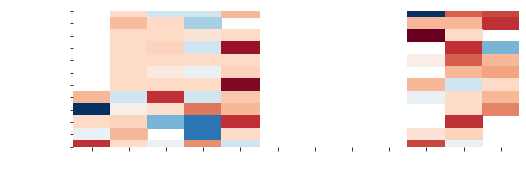

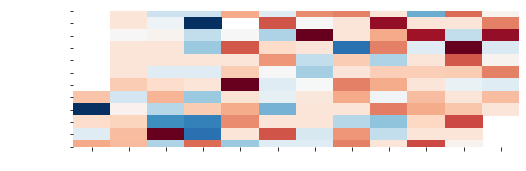

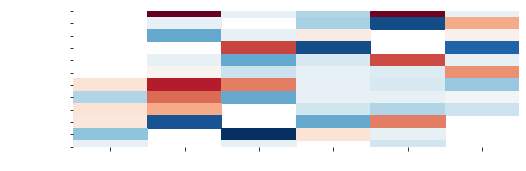

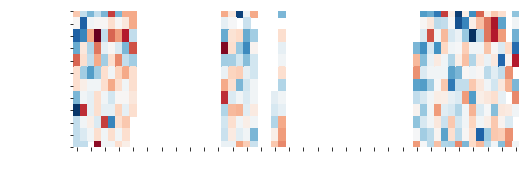

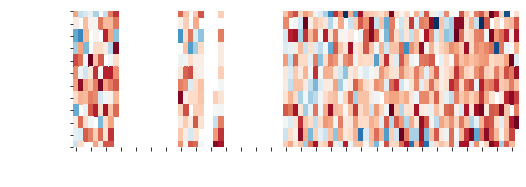

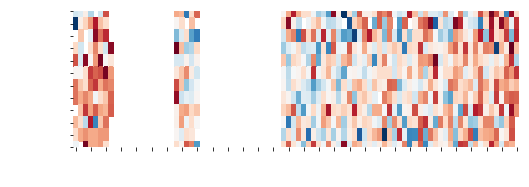

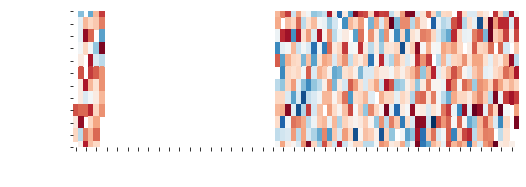

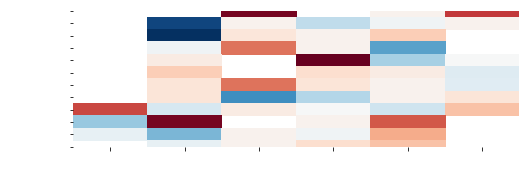

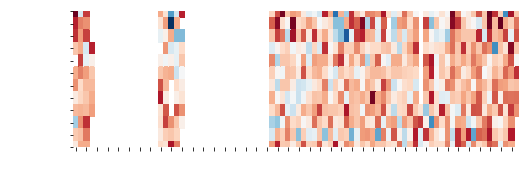

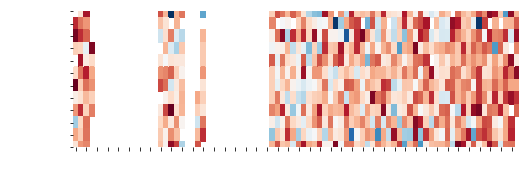

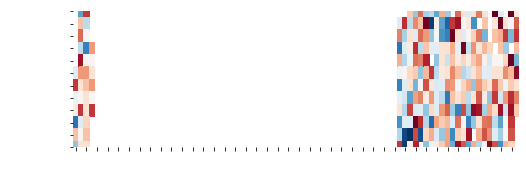

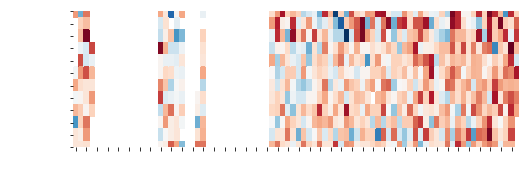

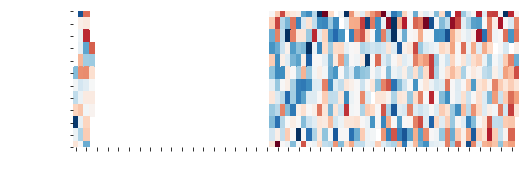

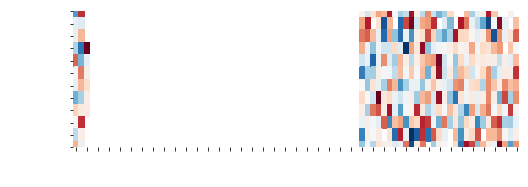

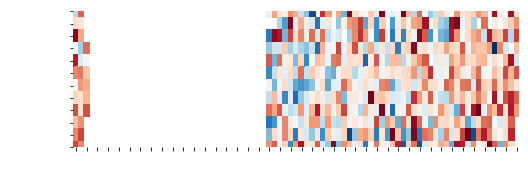

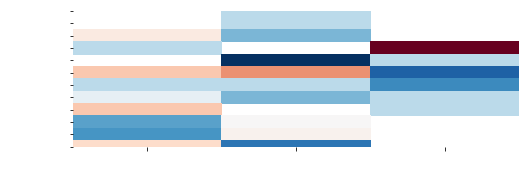

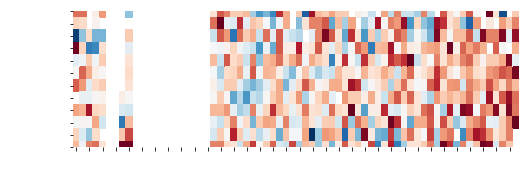

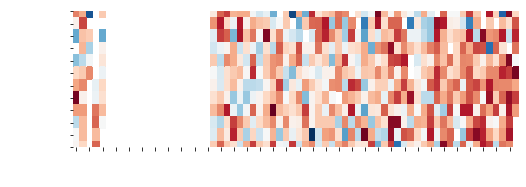

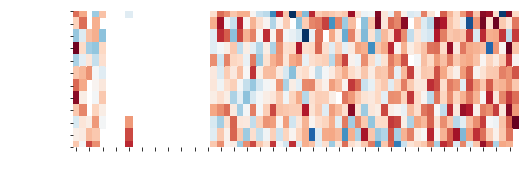

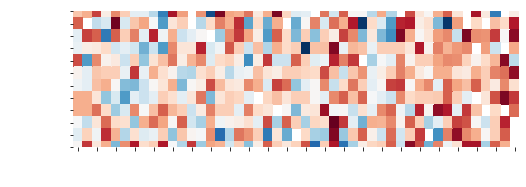

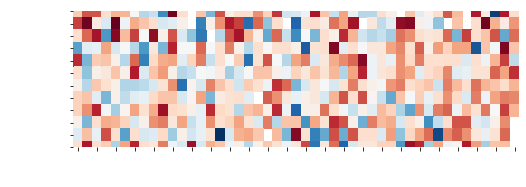

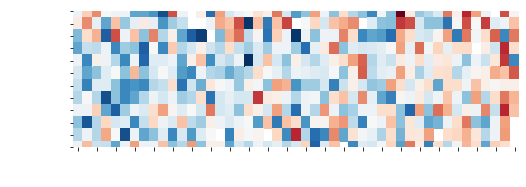

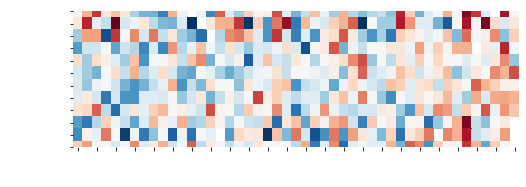

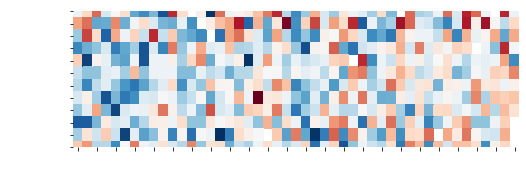

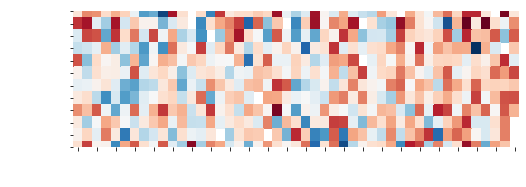

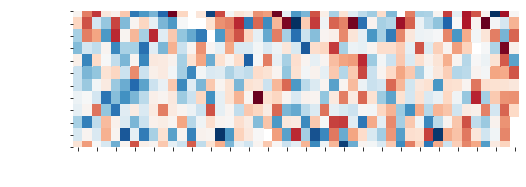

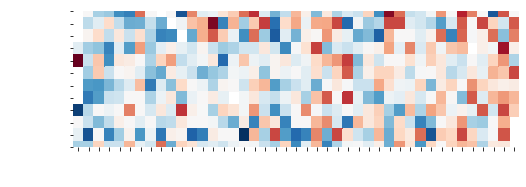

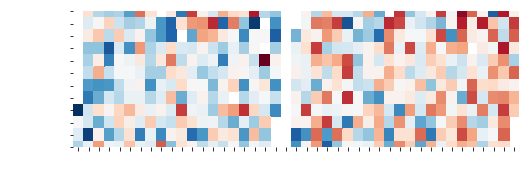

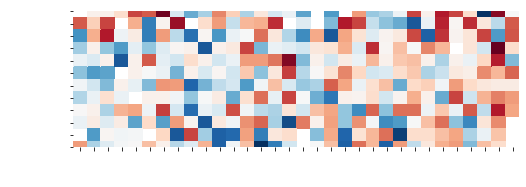

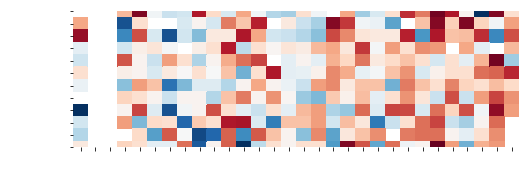

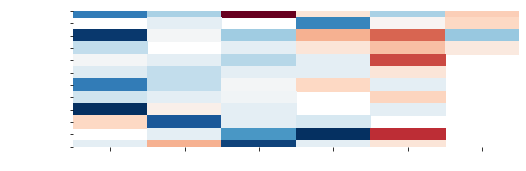

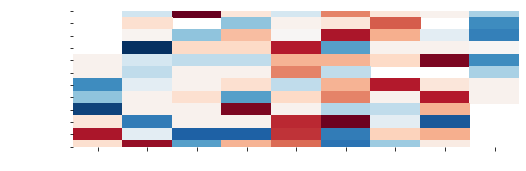

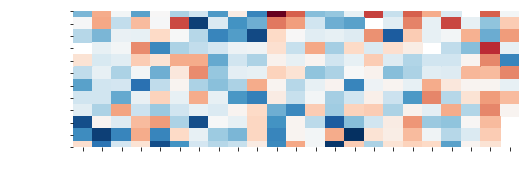

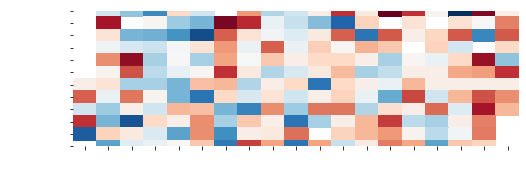

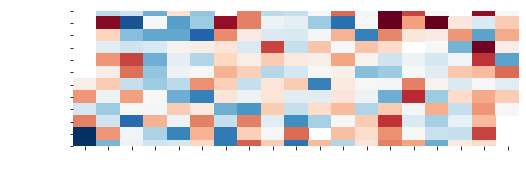

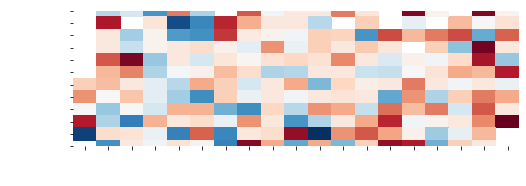

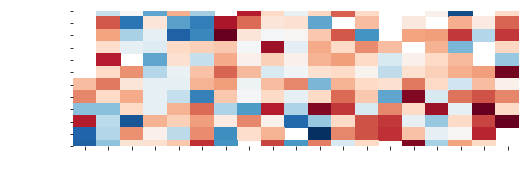

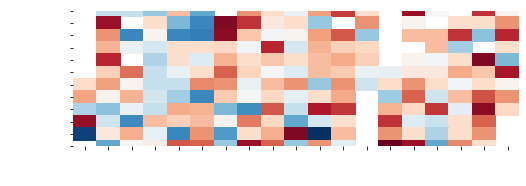

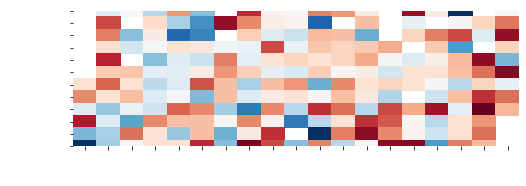

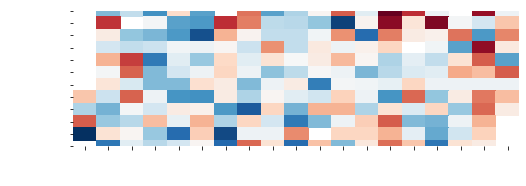

In [499]:
for station in df['ID'].unique():
    dy=dzn.loc[station].groupby(['year','month']).median()[['XTEMP']].unstack().T
    for i in range(min(dy.columns)+1,max(dy.columns)):
        if i not in dy.columns:
            dy[i]=np.nan
    dy=dy[range(min(dy.columns),max(dy.columns)+1)]
    dy=dy[dy>dy.min().min()*0.7]
    dy=dy[dy<dy.max().max()*0.7]
    fig,ax=plt.subplots(1,1,figsize=(8,2.5))
    sns.heatmap(dy, linewidth=0,ax=ax, cmap='RdBu_r',cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels(['január','február','március','április','május','június','július','augusztus',
                        'szeptember','október','november','december'],color='w')
    ax.set_xticklabels(ax.get_xticklabels(),color='w')
    plt.savefig('carpet/'+str(station)+'.png',bbox_inches='tight',transparent=True)

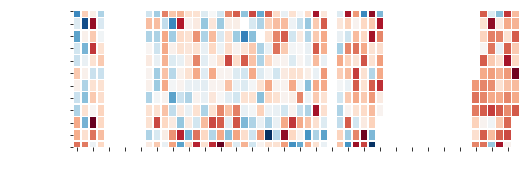

array([154200, 152590, 151110, 153100, 153600, 150800, 154500, 154600,
       150900, 152600, 154100, 151200, 154800, 153500, 152650, 154900,
       152000, 153460, 150100, 152470, 151500, 152800, 152300, 150400,
       151450, 150200, 154990, 150890, 152920, 150040, 150850, 151970,
       151700, 153770, 154050, 153730, 152350, 153400, 154700, 153870,
       152610, 153350, 150630, 154090, 151890, 154820, 150230, 152090,
       154440, 153750, 152890, 153380, 151940, 152960, 154910, 154810,
       150105, 151820, 152150, 153560, 152770, 153490, 154690, 151360,
       152990, 153550, 151090, 152170, 151990, 151680, 152040, 153160,
       151190, 151230, 154890, 152210, 150070, 154080, 153950, 150730,
       152620, 150410, 151400, 150950, 150320, 153000, 151320, 154240,
       152410, 152060, 119000, 151740, 153150, 154120, 152310, 154020,
       152540, 150090, 154160, 154230, 153690, 152670, 153250, 153450,
       151270, 151070, 153470, 154620, 152730, 150420, 153190, 150440,
      